In [3]:
import sys
import flap

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\core")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\core")
import core

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath

In [ ]:
path = r"E:\marci main\fusion\inputdata\AUGD_35628_tor_bal_raw.sav"
print(path)

obj = core.NWTDataObject()
obj.load_raw_sav(path)

In [ ]:
print(obj.raw_data.data)
flap.list_data_objects(obj.raw_data)

# testing with generated data

In [ ]:
samples = 1000
data = np.random.normal(0,1,samples)
plt.plot(data)

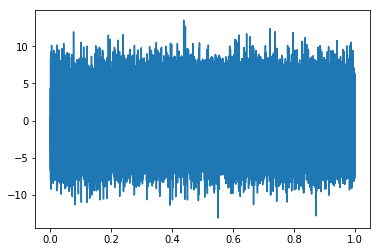

In [180]:
samples = 80000
f=15000
x = np.linspace(start=0,num=samples,stop=1)
data = 3*np.random.normal(0,1,samples)+0.15*np.sin(f*2*np.pi*x)
plt.plot(x,data)

In [181]:
n = 2*samples**0.5
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-1, nfft = 1.5*n)

In [ ]:
#%%script false
max = np.max(np.abs(stft))
plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.abs(stft), vmin=0, vmax=max, shading='plasma')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_abs")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.real, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Real')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_real")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.imag, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Imag')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_imag")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.angle(stft), vmin=-6, vmax=6, shading='plasma')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_phase")
plt.show()

In [182]:
search_r=10
ridgei=np.zeros(samples)
amplitude=np.zeros(samples,dtype=complex)
stft_abs=np.abs(stft)
ridgei[0]=np.argmax(stft_abs[:,0])

search_r=int(search_r)
for i in range(1,samples):
    if i%10000 == 0:
        print(ridgei[i-1])
    if ridgei[i-1] > search_r+1:
        ridgei[i]=np.argmax(stft_abs[int(ridgei[0])-search_r:int(ridgei[0])+search_r ,i])+ridgei[0]-search_r
    else: 
        ridgei[i]=np.argmax(stft_abs[0:int(ridgei[0])+search_r ,i])
    amplitude[i]=stft[int(ridgei[i]),i]
print(amplitude)

246.0
237.0
239.0
242.0
237.0
238.0
235.0
[ 0.        +0.j          0.24521909+0.05309822j -0.097913  +0.23236929j
 ...  0.14266188-0.22534393j  0.20741858+0.16640478j
 -0.18792292+0.18701193j]


In [ ]:
#plt.figure(figsize=(14,11))
#plt.imshow(stft.real,aspect='auto')
#plt.show()

plt.figure(figsize=(14,11))
plt.imshow(np.abs(stft[0:150,:]),aspect='auto')
plt.plot(ridgei[:],"r.-")
#plt.xlim(0,1500)
plt.show()

0j


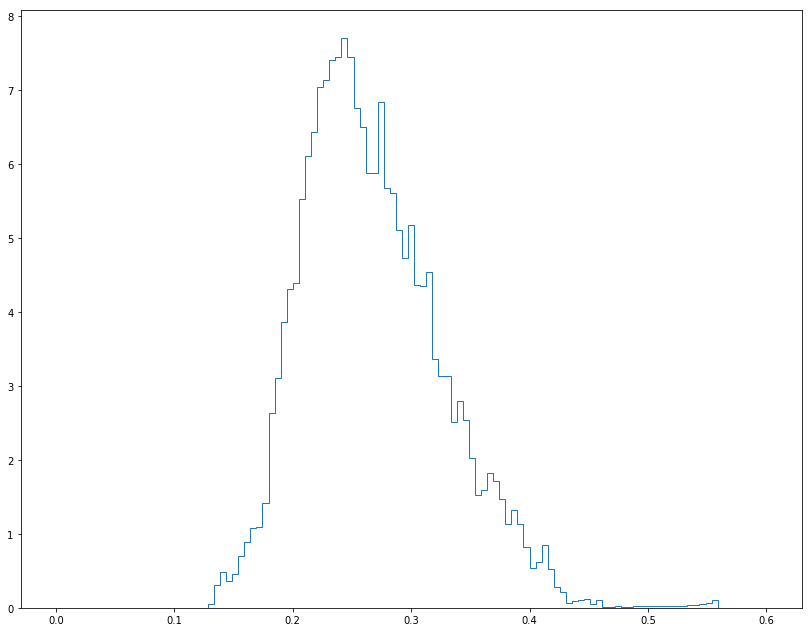

In [184]:
#c = np.abs(chosen).flatten()
#c = chosen.real.flatten()stft[0:15,0:1500]
print(amplitude[0])

#np.seterr(divide='ignore', invalid='ignore')

plt.figure(figsize=(14,11))
n, bins, patches = plt.hist(np.abs(amplitude), bins=117, density = True,facecolor='b',histtype='step',range=(0,0.6))#4.2,4.7
#plt.xlim(4.2,4.7)
plt.savefig("test_hist")
plt.show()

In [201]:
dist_x=bins[:-1]
shape_h=25
scale_h=90
loc_h=10
diff = np.zeros((shape_h,scale_h,loc_h))
shape = np.linspace(0,9,shape_h)
scale = np.linspace(0.03,0.07,scale_h)
loc = np.linspace(0.0,0.07,loc_h)
for i in range(shape_h):
    for j in range(scale_h):
        for k in range(loc_h):
            diff[i,j,k] = np.average((scipy.stats.rice.pdf(dist_x,shape[i],loc[k],scale[j])-n)**2)
    if i%2 == 0:
        print(i)
#print(divmod(diff.argmin(), diff.shape[1]))

0
2
4
6
8
10
12
14
16
18
20
22
24


8 70 9
3.0 0.05828282828282828 0.07


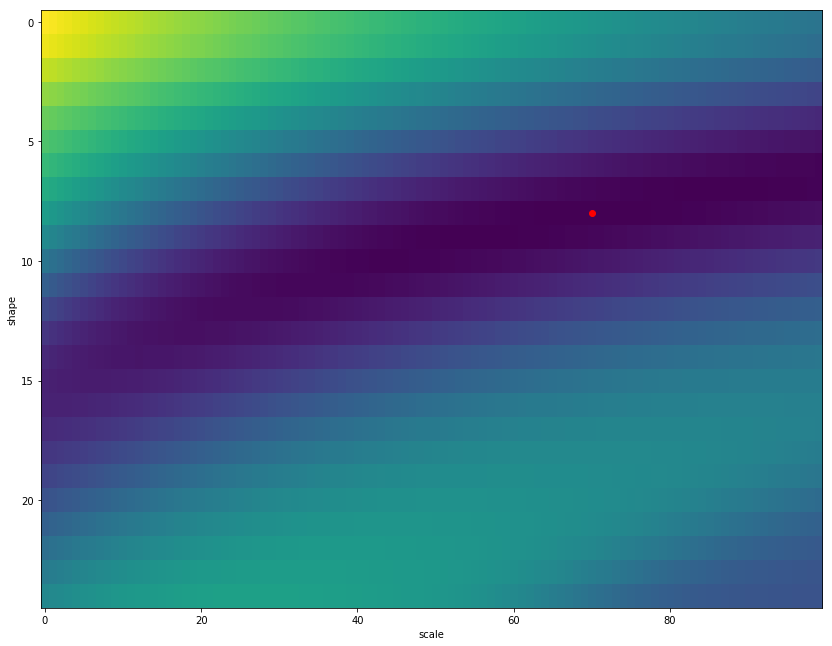

In [202]:
#mini = np.min(diff)
x1,y1,z1=np.unravel_index(diff.argmin(), diff.shape)
print(x1,y1,z1)
print(shape[x1],scale[y1],loc[z1])

plt.figure(figsize=(14,11))
plt.imshow(diff[:,:,z1],aspect='auto')
plt.plot(y1,x1,'ro')
plt.ylabel("shape")
plt.xlabel("scale")
plt.show()

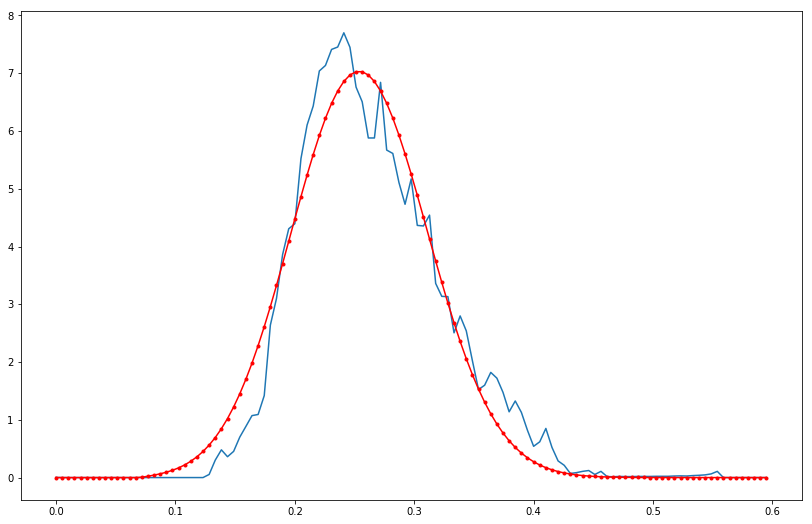

In [203]:
plt.figure(figsize=(14,9))
plt.plot(dist_x,n)#/np.max(n)
#x=np.linspace(3.5,5,500)
#plt.plot(dist_x,rv.pdf(dist_x*scale0)*scale0)#/np.max(rv.pdf(dist_x))
plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape[x1],loc[z1],scale[y1]),'r.-') 
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,140.0,0.0,0.032))
plt.savefig("teszt-rician-fit")
plt.show()